In [30]:
import tensorflow as tf
import numpy as np

In [31]:
class InputProcessLayer(tf.keras.layers.Layer):
    def __init__(self,emb_input_output_dims,dense_indices,sparse_indices,*args,**kwargs):
        super(InputProcessLayer,self).__init__(*args,**kwargs)
        assert len(sparse_indices)==len(emb_input_output_dims)

        self.dense_indices=dense_indices
        self.sparse_indices=sparse_indices
        self.emb_layers=list()
        for input_dim,output_dim in emb_input_output_dims:
            self.emb_layers.append(tf.keras.layers.Embedding(input_dim=input_dim,output_dim=output_dim))

    def call(self, inputs, **kwargs):
        feature_vectors=list()
        for i,sparse_index in enumerate(self.sparse_indices):
            feature_vectors.append(self.emb_layers[i](inputs[:,sparse_index]))

        dense_vector=tf.gather(inputs,indices=self.dense_indices,axis=1)
        feature_vectors.append(dense_vector)

        return tf.concat(feature_vectors,axis=1)

dense_input_arr=np.random.random(size=[5,3]).astype(np.float32)
sparse_input_arr=np.random.randint(0,3,size=[5,2]).astype(np.float32)
input_arr=np.concatenate((dense_input_arr,sparse_input_arr),axis=1)
input_process_layer=InputProcessLayer(emb_input_output_dims=[(3,4),(3,5)],dense_indices=[0,1,2],sparse_indices=[3,4])
input_process_layer(input_arr)


<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[-0.04400048, -0.03237075, -0.03137156,  0.00961976,  0.0452953 ,
         0.01645778, -0.00754809,  0.03514223,  0.03108365,  0.34325156,
         0.38085416,  0.61500335],
       [ 0.01053082,  0.02287744,  0.02812685,  0.0432727 ,  0.0452953 ,
         0.01645778, -0.00754809,  0.03514223,  0.03108365,  0.8867829 ,
         0.4303342 ,  0.6087551 ],
       [-0.00229781, -0.04657988, -0.03880503, -0.01879505,  0.03517852,
        -0.01557446,  0.03966014, -0.04239425, -0.03867513,  0.45097062,
         0.656106  ,  0.3268893 ],
       [ 0.01053082,  0.02287744,  0.02812685,  0.0432727 , -0.01413301,
         0.01785595, -0.04073424, -0.04205858,  0.0430199 ,  0.6532049 ,
         0.2585996 ,  0.9213414 ],
       [-0.00229781, -0.04657988, -0.03880503, -0.01879505,  0.03517852,
        -0.01557446,  0.03966014, -0.04239425, -0.03867513,  0.55641764,
         0.36989325,  0.29279754]], dtype=float32)>

In [33]:
class CrossLayer(tf.keras.layers.Layer):
    def __init__(self,L1,*args,**kwargs):
        super(CrossLayer,self).__init__(*args,**kwargs)
        self.L1=L1

    def build(self, input_shape):
        """

        :param input_shape: [batch_size,feature_dim]
        :return:
        """
        feature_dim=input_shape[1]
        self.ws=list()
        self.biases=list()
        for _ in range(self.L1):
            self.ws.append(tf.Variable(tf.random.truncated_normal(shape=[feature_dim,1])))
            self.biases.append(tf.Variable(tf.zeros(shape=[feature_dim,1])))

    def call(self, inputs, **kwargs):
        x=tf.expand_dims(inputs,axis=2) # [batch_size,feature_dim,1]
        x0=tf.expand_dims(inputs,axis=2) # [batch_size,feature_dim,1]
        for i in range(self.L1):
            weight=self.ws[i]
            bias=self.biases[i]
            x=tf.matmul(tf.matmul(x0,x,transpose_b=True),weight)+x+bias
        return tf.squeeze(x)

input_arr=np.random.random(size=[5,10]).astype(np.float32)
cross_layer=CrossLayer(L1=1)
cross_layer(input_arr)



<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[-2.26311386e-03, -1.10330582e-02, -1.15504265e-02,
        -9.94515419e-03, -2.39977613e-04, -1.31931901e-02,
        -1.20897889e-02, -2.86319852e-03, -5.89779019e-03,
        -3.90406698e-04],
       [ 3.19686621e-01,  5.81986964e-01,  8.07755470e-01,
         3.77466232e-01,  6.06803536e-01,  1.10015368e+00,
         1.14674735e+00,  2.35307589e-01,  1.21765316e+00,
         9.75310564e-01],
       [ 7.27633536e-01,  1.50614858e+00,  1.21667385e+00,
         1.23708797e+00,  1.09976017e+00,  1.71667075e+00,
         1.54814923e+00,  9.32284951e-01,  5.11483908e-01,
         1.23160934e+00],
       [ 1.05419159e+00,  1.37350142e+00,  2.80103588e+00,
         2.03899670e+00,  2.15584731e+00,  2.30889320e+00,
         5.21077633e-01,  7.00688004e-01,  6.00037456e-01,
         9.92247224e-01],
       [ 5.76454163e-01,  1.05915713e+00,  1.42004120e+00,
         4.07276452e-01,  6.16940036e-02,  4.00536120e-01,
         9.41250145e-

In [47]:
class DCN(tf.keras.Model):
    def __init__(self,L1,deep_units_list,emb_input_output_dims,dense_indices,sparse_indices,scoring_units,*args,**kwargs):
        super(DCN,self).__init__(*args,**kwargs)
        self.L1=L1
        self.dense_layers=list()
        self.input_process_layer=InputProcessLayer(emb_input_output_dims,dense_indices,sparse_indices)
        self.cross_layer=CrossLayer(L1=L1)
        for deep_units in deep_units_list:
            self.dense_layers.append(tf.keras.layers.Dense(units=deep_units,activation=tf.nn.relu))
        self.scoring_layer=tf.keras.layers.Dense(units=scoring_units,activation=tf.nn.sigmoid)
    def call(self, inputs, training=None, mask=None):
        x0=self.input_process_layer(inputs)
        x_L=self.cross_layer(x0)
        h_L=x0
        for dense_layer in self.dense_layers:
            h_L=dense_layer(h_L)

        x_stack=tf.concat([x_L,h_L],axis=1)
        p=self.scoring_layer(x_stack)

        return p

dense_input_arr=np.random.random(size=[5,3]).astype(np.float32)
sparse_input_arr=np.random.randint(0,3,size=[5,2]).astype(np.float32)
input_arr=np.concatenate((dense_input_arr,sparse_input_arr),axis=1)
dcn=DCN(L1=2,deep_units_list=[4,4,3],emb_input_output_dims=[(3,4),(3,5)],dense_indices=[0,1,2],sparse_indices=[3,4],scoring_units=2)
dcn(input_arr)

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[-1.70129421e-03,  2.14517582e-03,  7.80998496e-04,
         3.18245124e-03,  9.03166481e-04, -4.59139352e-04,
        -4.31151595e-03, -2.95757595e-03,  3.12200282e-03,
        -1.66146215e-02, -5.63660972e-02, -7.14858770e-02,
         1.87712703e-02,  0.00000000e+00,  0.00000000e+00],
       [-2.22522346e-03, -2.42970162e-03, -2.14223703e-03,
         2.33350135e-03, -5.84230293e-04,  2.97003193e-04,
         2.78898864e-03,  1.91316614e-03, -2.01952877e-03,
         5.37679233e-02,  4.76751141e-02,  9.19804908e-04,
         1.48985550e-01,  5.33553250e-02,  0.00000000e+00],
       [-4.65412065e-03, -5.29240817e-04,  1.29015883e-03,
        -2.34279200e-03, -9.52462316e-04, -3.68542736e-03,
         2.99443956e-03, -3.05592408e-03, -4.98449756e-03,
        -1.04080914e-02, -6.32554889e-02, -1.08982995e-01,
         1.99426245e-02,  0.00000000e+00,  0.00000000e+00],
       [ 3.32489610e-03,  3.63041461e-03,  3.20088584e-03,
    

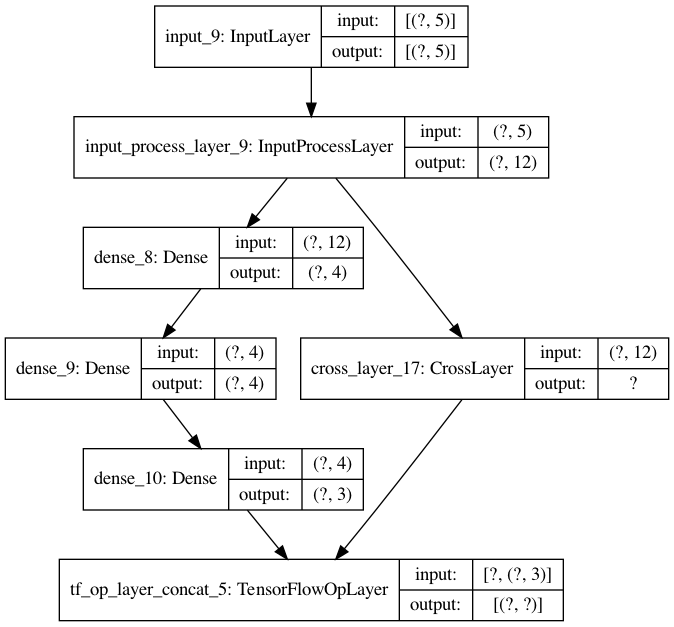

In [48]:
inputs=tf.keras.Input(shape=[5],batch_size=None)
outputs=dcn.call(inputs)
dcn_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
tf.keras.utils.plot_model(dcn_for_plot,show_shapes=True,expand_nested=True)


In [41]:
outputs

<tf.Tensor 'dense_3/Sigmoid:0' shape=(None, 2) dtype=float32>